# Using Lime with Pytorch

In this tutorial we will show how to use Lime framework with Pytorch. Specifically, we will use Lime to explain the prediction generated by one of the pretrained ImageNet models.

Let's start with importing our dependencies. This code is tested with Pytorch 1.0 but should work with older versions as well.

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

Load our test image and see how it looks.

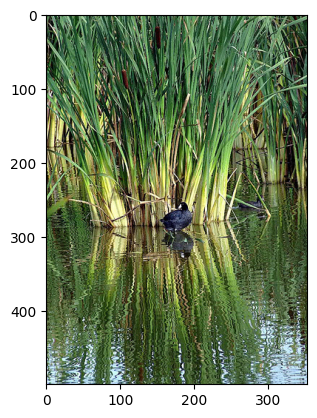

In [87]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('../../../imagenet-sample-images/n02018207_American_coot.JPEG')
plt.imshow(img)

We need to convert this image to Pytorch tensor and also apply whitening as used by our pretrained model.

In [88]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

Load the pretrained model for Resnet50 available in Pytorch.

In [76]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(torch.device("mps"))

Load label texts for ImageNet predictions so we know what model is predicting

In [89]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('./data/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}    

Get the predicition for our image.

In [90]:
img_t = get_input_tensors(img).to(torch.device("mps"))
model.eval()
logits = model(img_t)

Predicitions we got are logits. Let's pass that through softmax to get probabilities and class labels for top 5 predictions.

In [91]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].cpu().detach().numpy(), probs5[1][0].cpu().detach().numpy()))

((np.float32(0.4843908), np.int64(137), 'American_coot'),
 (np.float32(0.05600795), np.int64(36), 'terrapin'),
 (np.float32(0.020368692), np.int64(50), 'American_alligator'),
 (np.float32(0.019572992), np.int64(136), 'European_gallinule'),
 (np.float32(0.0098647345), np.int64(135), 'limpkin'))

We are getting ready to use Lime. Lime produces the array of images from original input image by pertubation algorithm. So we need to provide two things: (1) original image as numpy array (2) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output. 

For Pytorch, first we need to define two separate transforms: (1) to take PIL image, resize and crop it (2) take resized, cropped image and apply whitening.

In [92]:
def get_pil_transform(): 
    transf = transforms.Compose([
        # transforms.Resize((256, 256)),
        # transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

Now we are ready to define classification function that Lime needs. The input to this function is numpy array of images where each image is ndarray of shape (channel, height, width). The output is numpy aaray of shape (image index, classes) where each value in array should be probability for that image, class combination.

In [93]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("mps")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Let's test our function for the sample image.

In [94]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

np.int64(137)

Import lime and create explanation for this prediciton.

In [19]:
from lime import lime_image

In [95]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         batch_size=10,
                                        #  num_features=100000,
                                         num_samples=600) # number of images that will be sent to classification function

  0%|          | 0/600 [00:00<?, ?it/s]

Let's use mask on image and see the areas that are encouraging the top prediction.

In [21]:
from skimage.segmentation import mark_boundaries

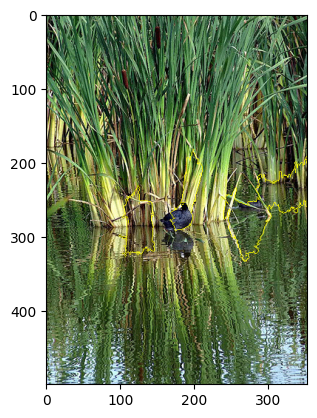

In [96]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

Let's turn on areas that contributes against the top prediction.

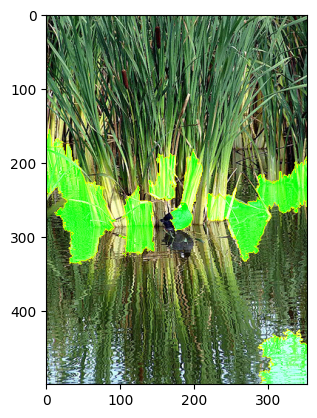

In [97]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [24]:
# Add these functions to your notebook after the LIME imports

import cv2

def compute_iou_from_lime_mask(mask, threshold=0.5, ground_truth_bbox=None, ground_truth_mask=None):
    """
    Compute Intersection over Union (IoU) between LIME mask and ground truth.
    
    Args:
        mask: 2D numpy array representing the LIME segmentation mask
        threshold: float, not used for LIME masks (they're already binary)
        ground_truth_bbox: tuple (x1, y1, x2, y2) representing bounding box coordinates
        ground_truth_mask: 2D numpy array representing ground truth binary mask
    
    Returns:
        iou_score: float, IoU score between 0 and 1
        lime_bbox: tuple, bounding box extracted from LIME mask
        binary_mask: 2D numpy array, the LIME mask
    """
    # LIME masks are already binary, but ensure they're uint8
    binary_mask = mask.astype(np.uint8)
    
    # Extract bounding box from LIME mask using connected components
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return 0.0, None, binary_mask
    
    # Find largest contour (assuming it's the main object)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    lime_bbox = (x, y, x + w, y + h)
    
    if ground_truth_bbox is not None:
        # Compute IoU with ground truth bounding box
        iou_score = compute_bbox_iou(lime_bbox, ground_truth_bbox)
    elif ground_truth_mask is not None:
        # Compute IoU with ground truth mask
        iou_score = compute_mask_iou(binary_mask, ground_truth_mask)
    else:
        print("Warning: No ground truth provided. Returning LIME bbox only.")
        return None, lime_bbox, binary_mask
    
    return iou_score, lime_bbox, binary_mask


def compute_bbox_iou(bbox1, bbox2):
    """
    Compute IoU between two bounding boxes.
    
    Args:
        bbox1: tuple (x1, y1, x2, y2)
        bbox2: tuple (x1, y1, x2, y2)
    
    Returns:
        iou: float, IoU score
    """
    x1_1, y1_1, x2_1, y2_1 = bbox1
    x1_2, y1_2, x2_2, y2_2 = bbox2
    
    # Calculate intersection
    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)
    
    if x2_i <= x1_i or y2_i <= y1_i:
        return 0.0
    
    intersection = (x2_i - x1_i) * (y2_i - y1_i)
    
    # Calculate union
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0.0


def compute_mask_iou(mask1, mask2):
    """
    Compute IoU between two binary masks.
    
    Args:
        mask1: 2D numpy array (binary)
        mask2: 2D numpy array (binary)
    
    Returns:
        iou: float, IoU score
    """
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    
    return intersection / union if union > 0 else 0.0


def visualize_lime_iou_result(original_img, lime_mask, lime_bbox, ground_truth_bbox=None, iou_score=None):
    """
    Create visualization showing LIME mask and bounding boxes.
    
    Returns:
        visualization: numpy array containing the combined visualization
    """
    # Convert original image to proper format
    if original_img.max() <= 1.0:
        original_vis = (original_img * 255).astype(np.uint8)
    else:
        original_vis = original_img.astype(np.uint8)
    
    # Create mask visualization
    mask_vis = np.stack([lime_mask * 255] * 3, axis=-1).astype(np.uint8)
    
    # Create overlay of mask on original image
    overlay = original_vis.copy()
    overlay[lime_mask > 0] = [0, 255, 0]  # Green for positive regions
    overlay_vis = cv2.addWeighted(original_vis, 0.7, overlay, 0.3, 0)
    
    # Draw bounding boxes
    bbox_vis = original_vis.copy()
    
    if lime_bbox is not None:
        # Draw LIME bounding box in green
        cv2.rectangle(bbox_vis, (lime_bbox[0], lime_bbox[1]), (lime_bbox[2], lime_bbox[3]), (0, 255, 0), 2)
        cv2.putText(bbox_vis, 'LIME', (lime_bbox[0], lime_bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    if ground_truth_bbox is not None:
        # Draw ground truth bounding box in red
        cv2.rectangle(bbox_vis, (ground_truth_bbox[0], ground_truth_bbox[1]), 
                     (ground_truth_bbox[2], ground_truth_bbox[3]), (255, 0, 0), 2)
        cv2.putText(bbox_vis, 'GT', (ground_truth_bbox[0], ground_truth_bbox[1] - 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    
    if iou_score is not None:
        cv2.putText(bbox_vis, f'IoU: {iou_score:.3f}', (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Combine visualizations
    combined = np.hstack([original_vis, mask_vis, overlay_vis, bbox_vis])
    
    return combined

IoU Score: 0.0000
LIME Bounding Box: (0, 156, 94, 336)
Ground Truth Bounding Box: (137, 239, 214, 305)


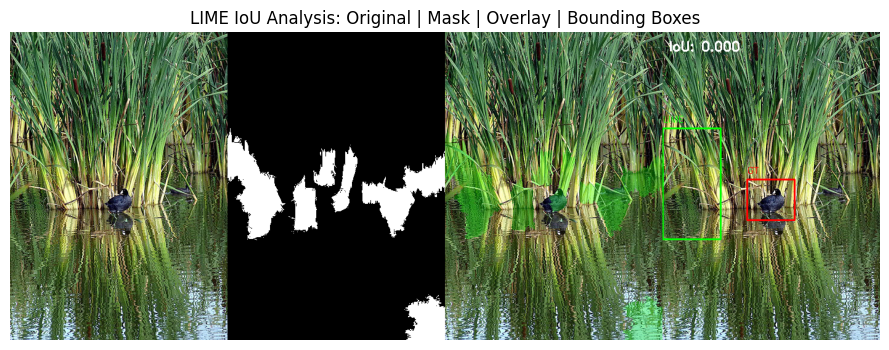

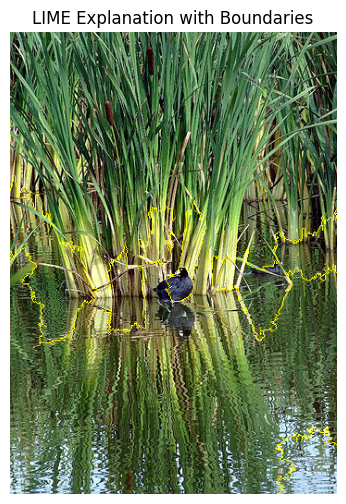

In [98]:
# Replace the cell with temp, mask = explanation.get_image_and_mask(...) with this:

# Get LIME explanation for positive regions only
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)

# Example ground truth bounding box for American coot (you'll need to adjust these coordinates)
# Format: (x1, y1, x2, y2) - coordinates of the bounding box
ground_truth_bbox = (137, 239, 214, 305)  # Replace with actual coordinates

# Compute IoU
iou_score, lime_bbox, binary_mask = compute_iou_from_lime_mask(
    mask, 
    ground_truth_bbox=ground_truth_bbox
)

print(f"IoU Score: {iou_score:.4f}")
print(f"LIME Bounding Box: {lime_bbox}")
print(f"Ground Truth Bounding Box: {ground_truth_bbox}")

# Create visualization
lime_iou_vis = visualize_lime_iou_result(
    temp, mask, lime_bbox, ground_truth_bbox, iou_score
)

# Display the combined visualization
plt.figure(figsize=(16, 4))
plt.imshow(lime_iou_vis)
plt.title('LIME IoU Analysis: Original | Mask | Overlay | Bounding Boxes')
plt.axis('off')
plt.show()

# Also show the original LIME boundary visualization
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.figure(figsize=(8, 6))
plt.imshow(img_boundry2)
plt.title('LIME Explanation with Boundaries')
plt.axis('off')
plt.show()